# Prevendo Notas do ENEM

O objetivo dessa análise é desenvolver um modelo que seja capaz de prever a nota no ENEM de um participante, baseado em dados socioeconômicos sobre ele.
<br><br>
O objetivo é que, a partir dessas previsões, a gente consiga analisar quais variáveis possuem maior impacto na previsão, o que pode ajudar a avaliar a necessidade do sistema de cotas.
<br><br>
Iremos julgar como injustiça um parâmetro que supostamente não deveria ser relevante para decidir a nota do participante, mas que o modelo julgou como relevante.

## Baixando dados

Os dados originais do ENEM 2022 já foram tratados para o modelo nos arquivos de tratamento.
<br><br>
Agora, os datasets de microdados e hábitos de estudo serão juntados, usando o código de inscrição dos participantes.

In [2]:
# Bibliotecas importantes
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df_microdados = pd.read_csv("microdados_tratado.csv")
df_estudo = pd.read_csv("habitos_estudo_tratado.csv")

In [4]:
# Tamanho dos datasets originais
print(f"Tamanho Microdados: {len(df_microdados)}")
print(f"Tamanho Hábitos Estudo: {len(df_estudo)}")

Tamanho Microdados: 669781
Tamanho Hábitos Estudo: 78241


In [6]:
# Juntando datasets
df = pd.merge(df_microdados, df_estudo, on="NU_INSCRICAO")
df

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,FAIXA_SALARIAL,RACA_AMARELA,RACA_BRANCA,RACA_INDIGENA,RACA_PARDA,...,PANDEMIA_GESTAO,PANDEMIA_PRATICAS,GESTAO,PRATICAS,Q025,Q026,Q028,Q030,Q032,Q033
0,210056012033,3,0,1.0,0.0,4,False,True,False,False,...,2.25,1.583333,1.0,1.0,2,2,4,2,2,2
1,210057478691,3,0,1.0,0.0,0,False,False,False,True,...,1.50,1.500000,0.0,0.5,2,2,6,2,2,2
2,210056688095,4,1,1.0,0.0,1,False,False,False,False,...,1.00,1.000000,1.0,1.0,2,1,1,1,1,1
3,210057511905,3,0,1.0,0.0,0,False,False,False,True,...,1.25,1.583333,2.0,2.0,1,1,1,1,1,1
4,210057838909,3,0,1.0,0.0,1,False,False,False,True,...,1.00,1.166667,1.0,1.0,2,2,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21818,210057405995,3,1,0.0,0.0,4,False,False,False,True,...,1.75,2.166667,1.5,3.0,2,1,1,2,2,2
21819,210055900340,2,1,0.0,0.0,8,False,False,False,True,...,1.75,1.250000,1.0,1.5,2,2,2,2,2,2
21820,210054991409,3,1,1.0,0.0,3,False,True,False,False,...,1.00,1.000000,0.0,0.0,2,2,2,1,2,2
21821,210055081282,6,1,1.0,0.0,1,False,False,False,True,...,0.00,0.000000,0.0,0.0,2,2,2,2,1,1


In [7]:
# Quantas linhas sobrariam se removessemos NAs?
df.dropna().shape[0]

21823

In [8]:
# Quanto é esse valor, em porcentagem, em relaçao ao dataset original do ENEM 2022?
# Se for ver nos outros arquivos, o número total de candidatos é 2.467.086
TAMANHO_TOTAL = 2467086
tamanho_novo  = df.dropna().shape[0]
100 * tamanho_novo / TAMANHO_TOTAL

0.8845658400234122

In [10]:
# Retirando o NU_INSCRICAO, pois foi usado somente para juntar os datasets
df.drop("NU_INSCRICAO", axis=1, inplace=True)

Juntando os datasets, temos apenas 0,88% dos dados originais do ENEM 2022. Isso significa que a amostra que estamos lidando é de 0,88% da população total (onde a população são os participantes do ENEM 2022). Embora seja um valor relativamente baixo, ainda é possível fazer boas análises, contanto que essa amostra seja representativa. 

## Train/Test Split e Feature Scaling

<Axes: xlabel='NOTA_TOTAL', ylabel='Count'>

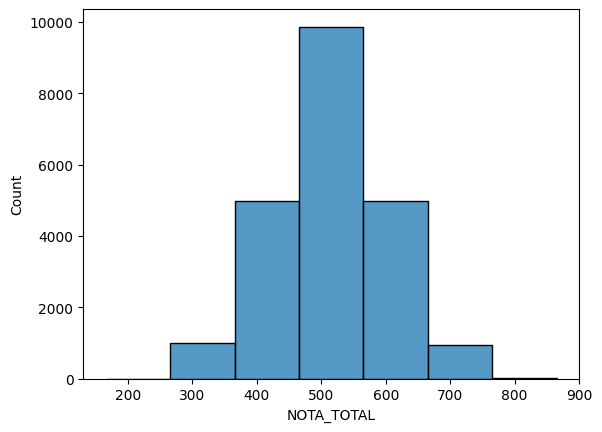

In [11]:
# Proporção das notas
import seaborn as sns
sns.histplot(x=df["NOTA_TOTAL"], binwidth=100)

In [12]:
# Para garantir que os datasets de treino e teste sigam essa proporção, é interessante criar um parâmetro auxiliar
# O parâmetro irá controlar em qual faixa a nota se encontra (0-100, 100-200, ...)
from math import floor
faixa = 100
auxiliar = np.floor(df["NOTA_TOTAL"] / faixa).astype(int)
auxiliar

0        7
1        4
2        5
3        3
4        4
        ..
21818    6
21819    5
21820    4
21821    3
21822    5
Name: NOTA_TOTAL, Length: 21823, dtype: int64

In [13]:
# Fazendo split de treino/teste
from sklearn.model_selection import train_test_split
X = df.drop("NOTA_TOTAL", axis=1)
Y = df["NOTA_TOTAL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=auxiliar)

<Axes: xlabel='NOTA_TOTAL', ylabel='Count'>

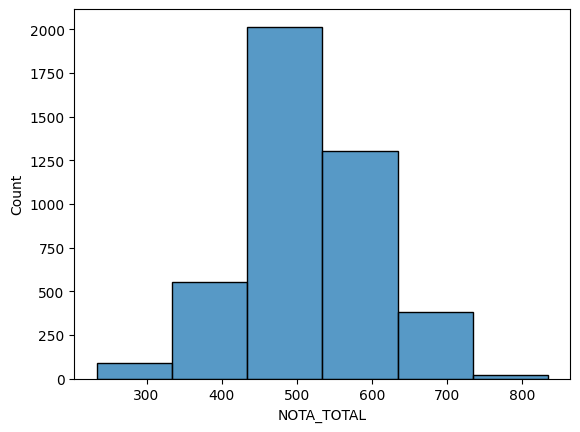

In [14]:
# Teste
import seaborn as sns
sns.histplot(x=y_test, binwidth=100)

<Axes: xlabel='NOTA_TOTAL', ylabel='Count'>

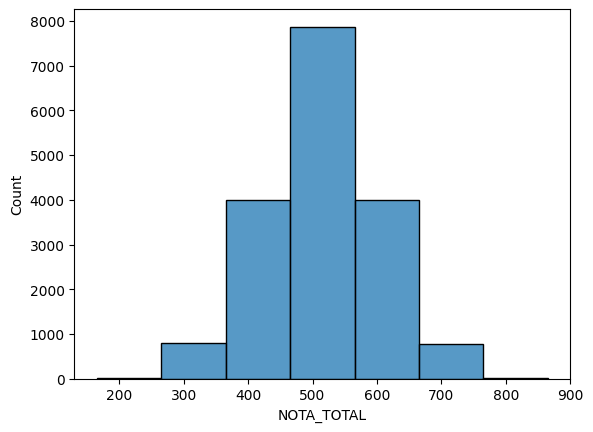

In [15]:
# Treino
import seaborn as sns
sns.histplot(x=y_train, binwidth=100)

In [16]:
# Fazendo MinMaxScaling para garantir que todas as variáveis estão na mesma escala
# Será guardado em variáveis à parte, já que nem todos os modelos precisam
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns)
X_test_scaled

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,FAIXA_SALARIAL,RACA_AMARELA,RACA_BRANCA,RACA_INDIGENA,RACA_PARDA,RACA_PRETA,...,PANDEMIA_GESTAO,PANDEMIA_PRATICAS,GESTAO,PRATICAS,Q025,Q026,Q028,Q030,Q032,Q033
0,0.052632,0.0,1.0,0.0,0.0625,0.0,0.0,0.0,1.0,0.0,...,0.416667,0.416667,0.500000,0.500000,1.0,1.0,0.117647,1.0,0.0,0.0
1,0.052632,0.0,0.0,0.0,0.2500,0.0,1.0,0.0,0.0,0.0,...,0.833333,0.527778,0.333333,0.666667,1.0,1.0,0.529412,1.0,1.0,0.0
2,0.157895,1.0,1.0,0.0,0.1875,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0
3,0.105263,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,1.0,0.0,...,0.083333,0.333333,0.333333,0.666667,0.0,0.0,0.117647,0.0,0.0,1.0
4,0.105263,0.0,1.0,0.0,0.2500,0.0,0.0,0.0,0.0,1.0,...,0.500000,0.388889,0.666667,0.500000,0.0,1.0,0.000000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4360,0.052632,0.0,1.0,0.0,0.4375,0.0,1.0,0.0,0.0,0.0,...,0.333333,0.305556,0.166667,0.166667,1.0,1.0,0.176471,0.0,0.0,1.0
4361,0.157895,1.0,1.0,0.0,0.3750,0.0,0.0,0.0,0.0,1.0,...,0.333333,0.388889,0.166667,0.166667,0.0,1.0,0.058824,1.0,1.0,1.0
4362,0.157895,0.0,1.0,0.0,0.0625,0.0,1.0,0.0,0.0,0.0,...,0.416667,0.333333,0.333333,0.333333,1.0,0.0,0.058824,0.0,1.0,1.0
4363,0.052632,0.0,0.0,0.0,0.1875,0.0,1.0,0.0,0.0,0.0,...,0.333333,0.194444,0.333333,0.333333,1.0,1.0,0.411765,0.0,1.0,1.0


## Testando modelo de Regressão Linear

### Desempenho do modelo nos dados de treino

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_test_scaled, y_test)

0.30104789132459886

O baixo score é de certa forma uma notícia boa. Isso significa que saber apenas saber sobre a situação socioeconômica do participante não é o suficiente para prever se o candidato foi bem ou não na prova do ENEM. Portanto, isso trás evidências de que o ENEM de fato está testando a inteligência do candidato.<br><br>
Entretanto, só porque o modelo de Regressão Linear não teve um bom desempenho, não quer dizer que outros modelos também não terão. 

### Variáveis relevantes

In [18]:
for feature, coef in zip(X.columns, reg.coef_):
    print(f"{feature}: {coef}")

TP_FAIXA_ETARIA: -119.83554823978243
TP_SEXO: 3.664055975311882
TP_ESCOLA: -46.77172395183064
TP_ENSINO: -34.374609336449765
FAIXA_SALARIAL: 90.96231181430257
RACA_AMARELA: -74756073989660.89
RACA_BRANCA: -74756073989644.7
RACA_INDIGENA: -74756073989664.06
RACA_PARDA: -74756073989657.92
RACA_PRETA: -74756073989658.61
NACIONALIDADE_1.0: -51007273684994.03
NACIONALIDADE_2.0: -51007273685007.91
NACIONALIDADE_3.0: -51007273685021.555
NACIONALIDADE_4.0: -51007273684983.2
REGIAO_CENTRO-OESTE: 323716188168353.2
REGIAO_NORDESTE: 323716188168359.1
REGIAO_NORTE: 323716188168354.3
REGIAO_SUDESTE: 323716188168363.06
REGIAO_SUL: 323716188168355.94
Q001: 23.514385734252357
Q002: -2.3566179558239226
Q003: 52.22778674593473
Q004: 11.374728317407799
Q034: -3.6299382889527267
PANDEMIA_GESTAO: 38.91062936151071
PANDEMIA_PRATICAS: -5.391207315279621
GESTAO: 18.407300526578354
PRATICAS: -28.912384438662375
Q025: 6.212889849856707
Q026: 6.569412578083443
Q028: 111.17868105543991
Q030: 14.16523276823258
Q032

## Testando modelo de RandomForest

### Desempenho do modelo nos dados de treino

In [19]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor().fit(X_train, y_train)
regr.score(X_test, y_test)

0.2830769429017498

Assim como no modelo de regressão linear, o RandomForest também teve um baixo desepenho, trazendo mais evidências de que as variáveis socioeconômicas sozinhas não são capazes de prever o desepenho do aluno no ENEM.

### Variáveis Relevantes

In [30]:
features = list(zip(regr.feature_importances_, X_train.columns))
features.sort(reverse=True)
for feature in features:
    print(f"{feature[1]}: {feature[0]}")

Q028: 0.14118796866479297
PANDEMIA_PRATICAS: 0.10265779740616263
TP_ESCOLA: 0.08800201948447971
FAIXA_SALARIAL: 0.08727318962791188
PANDEMIA_GESTAO: 0.07564323239333963
GESTAO: 0.05426865785622852
PRATICAS: 0.04774179869113509
TP_FAIXA_ETARIA: 0.044771120641278785
Q034: 0.03939207871609724
Q003: 0.029929221487374622
Q004: 0.029374830956015584
Q001: 0.02255240260721248
TP_SEXO: 0.0211706990251354
Q025: 0.019671197021828762
Q033: 0.01910926186363284
Q032: 0.01885327734770358
Q030: 0.01880312440005697
Q026: 0.01788907091580497
REGIAO_NORDESTE: 0.015569396848899018
RACA_BRANCA: 0.015031657407672455
REGIAO_SUDESTE: 0.014965152821356721
RACA_PARDA: 0.013360919201483974
REGIAO_NORTE: 0.011172336769523606
REGIAO_CENTRO-OESTE: 0.010298712026658108
RACA_PRETA: 0.009510577828616477
Q002: 0.009035450461567927
REGIAO_SUL: 0.008507113552307854
RACA_AMARELA: 0.00416115807478639
NACIONALIDADE_1.0: 0.0030911178454996065
NACIONALIDADE_2.0: 0.0029122172191349467
TP_ENSINO: 0.0022339875330879234
RACA_INDI

In [31]:
len(X.columns)

34